In [13]:
import pandas as pd
pd.options.display.max_columns=200
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.pipeline import make_pipeline
import bs4 as bs
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from wordcloud import WordCloud
from PIL import Image
from pandarallel import pandarallel

In [14]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import glob


#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

2023-04-18 12:31:36.850815: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 12:31:36.972428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 12:31:37.418999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-18 12:31:37.817966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [15]:
data_bow = pd.read_csv('data/data_bow.csv')

In [16]:
data_bow.head()

,Id,Body,Title,Tags,text
0,40101130,consider pd.series import panda import numpy n...,calculate rolling idxmax,<python><pandas><numpy><dataframe><series>,calculate rolling idxmax consider pd.series...
1,662383,'ve using time substring str_col patindex str_...,better technique trimming leading zero sql server,<sql><sql-server><sql-server-2005><tsql><string>,better technique trimming leading zero sql ser...
2,662421,trying install java application linux machine ...,x11 display variable mean,<java><linux><variables><x11><headless>,x11 display variable mean trying install ja...
3,3520133,library allows easily conveniently create obje...,object oriented callback,<c++><oop><callback><pointer-to-member><eiffel>,object oriented callback library allows eas...
4,1396164,edit whole question unclear want use openssl.n...,why n't .net find openssl.net dll,<c#><.net><dll><dllimport><dllnotfoundexception>,why n't .net find openssl.net dll edit whol...


In [17]:
#Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_bow[['Title','Body','text']], data_bow['Tags'], test_size=0.2, random_state=42)

In [77]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.9, min_df=2)
ctf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)

feat = 'Title'
cv_fit = cvect.fit(X_train[feat])
ctf_fit = ctf.fit(X_train[feat])

cv_transform_title = cv_fit.transform(X_train['Title'])
ctf_transform_title = ctf.transform(X_train['Title'])

cv_transform_text = cvect.transform(X_train['text'])
ctf_transform_text = ctf.transform(X_train['text'])

In [78]:
cv_transform_title.shape, ctf_transform_title.shape

((40000, 9073), (40000, 9073))

In [79]:
cv_transform_text.shape, ctf_transform_text.shape

((40000, 9073), (40000, 9073))

In [21]:
#type of cv_transform_title
type(cv_transform_title)

scipy.sparse._csr.csr_matrix

In [22]:
cv_fit.vocabulary_.get('python')

6209

In [23]:
#Classement des mots les plus fréquents

cv_sum = cv_transform_title.sum(axis=0)
cv_words_freq = [(word, cv_sum[0, idx]) for word, idx in cv_fit.vocabulary_.items()]
cv_words_freq =sorted(cv_words_freq, key = lambda x: x[1], reverse=True)
cv_words_freq[:10]

[('using', 3088),
 ('file', 2062),
 ('use', 1531),
 ('error', 1483),
 ('net', 1477),
 ('android', 1367),
 ('java', 1296),
 ('python', 1279),
 ('data', 1051),
 ('window', 987)]

In [101]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words_titles = gen_words(X_train['Title'])

print (data_words_titles[0:5])

[['how', 'exactly', 'remove', 'punctuation', 'using', 'package'], ['how', 'debug', 'bat', 'script'], ['how', 'get', 'utc', 'time', 'midnight', 'given', 'timezone'], ['meteor', 'native', 'osx', 'window', 'app'], ['any', 'quick', 'win', 'make', 'net', 'remoting', 'faster', 'single', 'machine']]


In [102]:
data_words = gen_words(X_train['text'])
print (data_words[0][0:20])

['how', 'exactly', 'remove', 'punctuation', 'using', 'package', 'update', 'think', 'may', 'workaround', 'solve', 'problem', 'add', 'one', 'code', 'dtms', 'dtm', 'remove', 'sparse', 'character']


In [103]:
from gensim.matutils import Sparse2Corpus

gensim_corpus_title_cv = Sparse2Corpus(cv_transform_title, documents_columns=False)
gensim_corpus_text_cv = Sparse2Corpus(cv_transform_text, documents_columns=False)
gensim_corpus_title_ctf = Sparse2Corpus(ctf_transform_title, documents_columns=False)
gensim_corpus_text_ctf = Sparse2Corpus(ctf_transform_text, documents_columns=False)

In [104]:
id2word_title_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_title_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_cv, id2word=id2word_title_cv)

id2word_text_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_text_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_cv, id2word=id2word_text_cv)

id2word_title_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_title_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_ctf, id2word=id2word_title_ctf)

id2word_text_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_text_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_ctf, id2word=id2word_text_ctf)

In [105]:
lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,
                                           id2word=id2word_title_cv,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [106]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_cv, gensim_corpus_title_cv, id2word_title_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.013189  0.073674       1        1  13.625223
0      0.050101 -0.411528       2        1  12.317752
1     -0.365935 -0.135630       3        1  11.954182
2     -0.224896  0.382459       4        1  10.323693
8      0.332474 -0.312146       5        1  10.078504
6      0.398604 -0.039892       6        1   9.949812
3      0.099662  0.441695       7        1   9.736800
7     -0.242471 -0.382504       8        1   8.430208
4     -0.426232  0.136357       9        1   7.832143
5      0.365504  0.247515      10        1   5.751682, topic_info=          Term         Freq        Total Category  logprob  loglift
3        using  3264.000000  3264.000000  Default  30.0000  30.0000
30        file  1752.000000  1752.000000  Default  29.0000  29.0000
21         net  1500.000000  1500.000000  Default  28.0000  28.0000
306        use  1767.000000  1767.000000  Default  27.0000  27.0000
75     android  1460.000000  1460.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
318   expected   110.720640   111.676189  Topic10  -4.7373   2.8471
547   datetime   101.498125   102.453541  Topic10  -4.8242   2.8463
2186     basic   100.194611   101.150163  Topic10  -4.8372   2.8462
1363     clang    99.471989   100.427407  Topic10  -4.8444   2.8461
984     effect    91.665935    92.621393  Topic10  -4.9261   2.8453

[330 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
80        2  0.999076   access
155       5  0.998660      add
750      10  0.995133  address
1315      8  0.996806     ajax
75        7  0.999515  android
...     ...       ...      ...
460       5  0.997788  working
131       2  0.997609      wpf
224       7  0.998402    write
127       3  0.998535    xcode
410       1  0.997158      xml

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 2, 3, 9, 7, 4, 8, 5, 6])

In [107]:
coherence_score_title_cv = CoherenceModel(model=lda_model_title_cv, texts=data_words_titles, dictionary=id2word_title_cv, coherence='c_v')
coherence_score_title_cv.get_coherence()

0.28963436517923175

In [108]:
lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,
                                                id2word=id2word_title_ctf,
                                                num_topics=20,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [109]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_ctf, gensim_corpus_title_ctf, id2word_title_ctf, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.291416  0.339230       1        1  10.763669
13     0.146553 -0.352487       2        1   6.522852
17    -0.284169 -0.240220       3        1   6.413036
18    -0.131126  0.343944       4        1   6.255312
0      0.284231 -0.248171       5        1   6.083145
15     0.336859 -0.104414       6        1   6.017714
11     0.064535  0.359856       7        1   5.852930
8     -0.162545 -0.342275       8        1   5.475837
6     -0.361183  0.112668       9        1   5.444363
3      0.256337  0.155696      10        1   5.364772
1      0.348602  0.040471      11        1   5.230650
10     0.027428  0.221702      12        1   4.828370
16    -0.339504 -0.091733      13        1   4.676221
5     -0.245600  0.234535      14        1   4.255870
19    -0.006179 -0.303884      15        1   3.784543
7     -0.108824  0.083127      16        1   3.539987
9     -0.004142 -0.164774      17        1   3.362597
2     -0.208198 -0.010152      18        1   2.897137
12     0.103870 -0.030338      19        1   2.773277
4     -0.008359 -0.002780      20        1   0.457717, topic_info=         Term         Freq        Total Category  logprob  loglift
3       using  2090.000000  2090.000000  Default  30.0000  30.0000
306       use  1278.000000  1278.000000  Default  29.0000  29.0000
30       file  1301.000000  1301.000000  Default  28.0000  28.0000
96     python  1087.000000  1087.000000  Default  27.0000  27.0000
75    android  1145.000000  1145.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1041     node     0.032206     2.581701  Topic20  -9.4414   1.0026
451       run     0.032206     2.582903  Topic20  -9.4414   1.0022
542      code     0.032206     2.582865  Topic20  -9.4414   1.0022
617    custom     0.032206     2.582252  Topic20  -9.4414   1.0024
1291    video     0.032206     2.581657  Topic20  -9.4414   1.0026

[1144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200      16  0.932698   abstract
80        1  0.993874     access
155      10  0.993497        add
262       9  0.906073     advice
27       15  0.979760  algorithm
...     ...       ...        ...
131      15  0.991435        wpf
224       4  0.993143      write
127      14  0.990028      xcode
410      17  0.987999        xml
361      18  0.962320       zoom

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 18, 19, 1, 16, 12, 9, 7, 4, 2, 11, 17, 6, 20, 8, 10, 3, 13, 5])

In [110]:
coherence_score_title_ctf = CoherenceModel(model=lda_model_title_ctf, texts=gensim_corpus_title_ctf, dictionary=id2word_title_ctf, coherence='c_v')
coherence_score_title_ctf.get_coherence()


nan

In [112]:
lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,
                                                id2word=id2word_text_cv,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [113]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_text_cv, gensim_corpus_text_cv, id2word_text_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.404660  0.094586       1        1  20.922577
2     -0.015618  0.146567       2        1  12.972136
7     -0.221469  0.328038       3        1  12.666011
0      0.197741 -0.177941       4        1  11.431670
8      0.433992 -0.084412       5        1   9.312802
6      0.337073  0.238289       6        1   8.939966
9      0.087998  0.448042       7        1   7.063330
3      0.124459 -0.473558       8        1   5.813828
1     -0.405904 -0.252008       9        1   5.587720
4     -0.133613 -0.267603      10        1   5.289961, topic_info=         Term          Freq         Total Category  logprob  loglift
67       java  27840.000000  27840.000000  Default  30.0000  30.0000
30       file  26498.000000  26498.000000  Default  29.0000  29.0000
696       org  20061.000000  20061.000000  Default  28.0000  28.0000
75    android  21631.000000  21631.000000  Default  27.0000  27.0000
257    string  21865.000000  21865.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
4706      yes   1167.870950   1844.170997  Topic10  -5.1706   2.4825
117      size   1664.586591   6944.948377  Topic10  -4.8162   1.5109
295    import   1345.486160  11354.072385  Topic10  -5.0290   0.8065
659       var   1247.184430  10712.449937  Topic10  -5.1049   0.7888
902    return   1198.349501  19670.440286  Topic10  -5.1448   0.1412

[539 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7945      3  0.999908   00
1798      9  0.998811   04
2263      8  0.049168   10
2263      9  0.950843   10
3143      9  0.999801   12
...     ...       ...  ...
5686      8  0.998225  xsd
4856      4  0.999560  xxx
4706      1  0.259737  yes
4706      9  0.106823  yes
4706     10  0.633347  yes

[869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 1, 9, 7, 10, 4, 2, 5])

In [72]:
lda_model_title = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word_title,
                                           num_topics=30,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

lda_model_title.save('models/lda_model_title.model')

In [73]:
lda_model_title = gensim.models.ldamodel.LdaModel.load('models/lda_model_title.model')

In [74]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title, corpus, id2word_title, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
24    -0.512409  0.159428       1        1  13.929950
1      0.176637 -0.441375       2        1   5.935472
0      0.411278  0.204126       3        1   4.987247
25     0.314306  0.310036       4        1   4.783271
19     0.435701 -0.173927       5        1   4.750131
21    -0.018947 -0.462992       6        1   4.653225
29    -0.248257  0.383722       7        1   4.103870
16     0.421426  0.053594       8        1   3.948035
12    -0.376609 -0.208144       9        1   3.830251
27    -0.416532 -0.043763      10        1   3.749160
13    -0.286987  0.236548      11        1   3.566154
28    -0.137149 -0.373322      12        1   3.460658
4     -0.268786 -0.326370      13        1   3.249884
17     0.350019 -0.029505      14        1   3.195049
11    -0.016259  0.431937      15        1   3.012774
18     0.283696 -0.290592      16        1   2.974310
23     0.244678 -0.163276      17        1   2.958024
22    -0.310565  0.096017      18        1   2.931202
2     -0.272138 -0.128336      19        1   2.740996
3      0.085956  0.355381      20        1   2.687120
15     0.190677  0.333162      21        1   2.572981
5     -0.128475  0.303792      22        1   2.481213
7     -0.011090  0.208948      23        1   2.331739
14     0.094196 -0.250749      24        1   1.803391
6      0.169301  0.099416      25        1   1.772841
20    -0.107815 -0.168470      26        1   1.442742
26     0.018656 -0.161285      27        1   1.143650
9     -0.107053  0.034778      28        1   0.821933
8      0.014495  0.005669      29        1   0.119899
10     0.008049  0.005552      30        1   0.062827, topic_info=          Term          Freq         Total Category  logprob  loglift
1          how  22597.000000  22597.000000  Default  30.0000  30.0000
5        using   8211.000000   8211.000000  Default  29.0000  29.0000
339        use   3644.000000   3644.000000  Default  28.0000  28.0000
32        file   4079.000000   4079.000000  Default  27.0000  27.0000
74        what   3700.000000   3700.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
23        make      0.009282    887.975784  Topic30  -9.7328  -4.0960
24         net      0.009282   3194.881221  Topic30  -9.7328  -5.3764
27      single      0.009282    368.111088  Topic30  -9.7328  -3.2155
28         win      0.009282    133.390888  Topic30  -9.7328  -2.2004
29   algorithm      0.009282    324.198177  Topic30  -9.7328  -3.0885

[1373 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
220      12  0.967848   abstract
89        5  0.997935     access
174      12  0.998676        add
285      12  0.966402     advice
29        7  0.993220  algorithm
...     ...       ...        ...
254       1  0.996993      write
145      27  0.996827      xcode
449       5  0.997675        xml
340      26  0.773519      xpath
398      13  0.985470       zoom

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 2, 1, 26, 20, 22, 30, 17, 13, 28, 14, 29, 5, 18, 12, 19, 24, 23, 3, 4, 16, 6, 8, 15, 7, 21, 27, 10, 9, 11])

In [ ]:
CoherenceModel(model=lda_model_title, texts=data_words_titles, dictionary=id2word_title_cv, coherence='c_v').get_coherence()

In [ ]:
id2word_text = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word_text.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word_text[[0][:1][0]]
print(word)

In [37]:
"""lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word_text,
                                           num_topics=30,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")"""

'lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,\n                                           id2word=id2word_text,\n                                           num_topics=30,\n                                           random_state=100,\n                                           update_every=1,\n                                           chunksize=100,\n                                           passes=10,\n                                           alpha="auto")'

In [38]:
"""pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word_text, mds="mmds", R=30)
vis"""

'pyLDAvis.enable_notebook()\nvis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word_text, mds="mmds", R=30)\nvis'

In [39]:
#Coherence score for LDA model
def compute_coherence_values(model, id2word):
      coherence_model_lda = CoherenceModel(model=model, texts=data_words, dictionary=id2word, coherence='c_v')
      return coherence_model_lda.get_coherence()

coherence_lda_title = compute_coherence_values(lda_model_title, id2word_text)
coherence_lda_title

0.31422408254627743

In [40]:
"""coherence_values = []
lda_models = {}  # Initialise un dictionnaire vide.

for i in range(5, 20):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word_text,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")
    coherence_values.append(compute_coherence_values(lda_model, id2word_text))

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models[i] = lda_model
    lda_model.save('models/lda_model_{}.model'.format(i))"""

'coherence_values = []\nlda_models = {}  # Initialise un dictionnaire vide.\n\nfor i in range(5, 20):\n    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,\n                                                id2word=id2word_text,\n                                                num_topics=i,\n                                                random_state=100,\n                                                update_every=1,\n                                                chunksize=100,\n                                                passes=10,\n                                                alpha="auto")\n    coherence_values.append(compute_coherence_values(lda_model, id2word_text))\n\n    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé\n    lda_models[i] = lda_model\n    lda_model.save(\'models/lda_model_{}.model\'.format(i))'

In [41]:
#load models from disk
lda_models = {}
for i in range(5, 20):
      lda_models[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_{}.model'.format(i))

In [42]:
coherence_values = []

for i in range(5, 20):
      lda_model = lda_models[i]
      coherence_values.append(compute_coherence_values(lda_model, id2word_text))

In [43]:
# print Coherence values
for m, cv in zip(range(5, 20), coherence_values):
      print("Num Topics =", m, "has Coherence Value of", round(cv, 4))

Num Topics = 5 has Coherence Value of 0.546
Num Topics = 6 has Coherence Value of 0.5707
Num Topics = 7 has Coherence Value of 0.561
Num Topics = 8 has Coherence Value of 0.5393
Num Topics = 9 has Coherence Value of 0.5752
Num Topics = 10 has Coherence Value of 0.5846
Num Topics = 11 has Coherence Value of 0.5219
Num Topics = 12 has Coherence Value of 0.5298
Num Topics = 13 has Coherence Value of 0.5114
Num Topics = 14 has Coherence Value of 0.5429
Num Topics = 15 has Coherence Value of 0.5517
Num Topics = 16 has Coherence Value of 0.5166
Num Topics = 17 has Coherence Value of 0.5124
Num Topics = 18 has Coherence Value of 0.513
Num Topics = 19 has Coherence Value of 0.4861


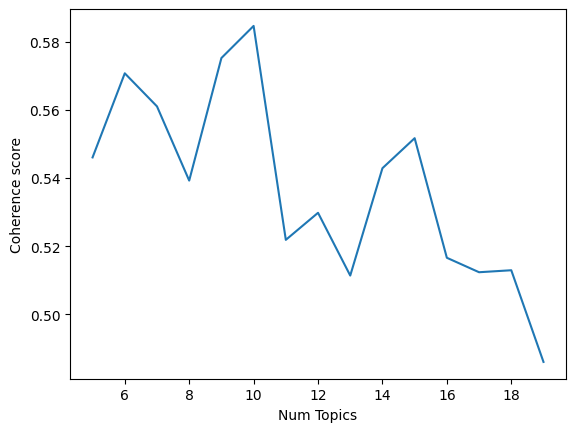

In [44]:
#plot coherence score

limit=20; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [45]:
#LDA vis for 10 topics
lda_model = lda_models[10]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word_text, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.308369  0.299530       1        1  32.277218
1      0.111067  0.269624       2        1  17.333327
7     -0.191039 -0.024225       3        1   9.101660
3     -0.103423  0.372768       4        1   7.809998
9      0.137105 -0.377429       5        1   7.205816
8     -0.352577  0.228419       6        1   6.856735
6     -0.157350 -0.382808       7        1   5.572751
0     -0.420026 -0.151026       8        1   5.196704
2      0.230424 -0.166581       9        1   4.399180
5      0.437451 -0.068271      10        1   4.246611, topic_info=            Term          Freq         Total Category  logprob  loglift
545         java  29877.000000  29877.000000  Default  30.0000  30.0000
639      android  21427.000000  21427.000000  Default  29.0000  29.0000
554          org  21420.000000  21420.000000  Default  28.0000  28.0000
949       string  24436.000000  24436.000000  Default  27.0000  27.0000
452        class  28987.000000  28987.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2498        menu   1143.026219   1829.118335  Topic10  -5.2459   2.6889
2410       style   1421.163679   4397.302145  Topic10  -5.0281   2.0295
1085        true   1261.467250  13026.219331  Topic10  -5.1473   0.8244
1345  background   1128.143165   3401.531653  Topic10  -5.2590   2.0554
80          text   1157.867651  11614.057279  Topic10  -5.2330   0.8534

[561 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
8249      9  0.999180    activerecord
2339     10  0.999493        activity
6598     10  0.998886  activitythread
6721      3  0.999008         adapter
2         1  0.303141             add
...     ...       ...             ...
1021      2  0.999489           xcode
569       6  0.291826             xml
569       7  0.554470             xml
569      10  0.153610             xml
1850      6  0.999311             xxx

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 8, 4, 10, 9, 7, 1, 3, 6])

In [46]:
num_topics = lda_model.num_topics  # Le nombre de topics dans le modèle.
num_words = 5  # Le nombre de mots clés à extraire pour chaque topic.

# Extraire les mots clés les plus importants pour chaque topic.
for i in range(num_topics):
    keywords = lda_model.show_topic(i, num_words)
    words = ', '.join([word for word, prob in keywords])
    print(f"Topic {i + 1}: {words}")

Topic 1: function, int, array, std, const
Topic 2: file, error, run, app, project
Topic 3: python, lib, import, module, node
Topic 4: user, server, request, client, service
Topic 5: like, using, use, the, would
Topic 6: android, view, item, app, com
Topic 7: java, org, jar, springframework, spring
Topic 8: string, class, public, new, return
Topic 9: name, data, value, table, php
Topic 10: image, text, self, div, html


In [47]:
Mtopics_words = lda_model.get_topics()
print(Mtopics_words)

[[4.1565451e-07 4.1565448e-07 4.1579881e-07 ... 4.3538918e-07
  4.1593205e-07 4.1579327e-07]
 [1.2452703e-07 1.2452641e-07 2.0032574e-03 ... 1.2521311e-07
  1.3542011e-07 1.2997326e-07]
 [4.6060532e-07 4.6060529e-07 4.6070411e-07 ... 4.6062539e-07
  4.6079472e-07 4.6070002e-07]
 ...
 [2.4365792e-07 2.4365787e-07 9.2397518e-03 ... 2.4403451e-07
  2.4674389e-07 2.4520088e-07]
 [3.0753012e-07 3.0752972e-07 1.7028494e-03 ... 3.0962761e-07
  3.0817344e-07 3.0785159e-07]
 [3.1586495e-07 3.1586492e-07 2.1737011e-03 ... 3.1648349e-07
  4.0518577e-07 3.6052535e-07]]


In [48]:
Mtopics_words.shape

(10, 148401)

In [49]:
Mtrain_quest_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)

In [50]:
# Récupérer le nombre de documents et de sujets
num_docs = len(corpus)
num_topics = lda_model.num_topics

# Initialiser une matrice vide de taille (num_docs x num_topics)
Mtrain_quest_topics_matrix = np.zeros((num_docs, num_topics))

# Remplir la matrice avec les probabilités de sujets pour chaque document
for doc_idx, doc_topics in enumerate(Mtrain_quest_topics):
    for topic, prob in doc_topics:
        Mtrain_quest_topics_matrix[doc_idx, topic] = prob

print(Mtrain_quest_topics_matrix)

[[0.00217101 0.20254929 0.03120382 ... 0.00430742 0.02376611 0.04226277]
 [0.01014825 0.27409428 0.00930768 ... 0.0183269  0.0164422  0.08106217]
 [0.00578294 0.02873266 0.0518531  ... 0.33031425 0.03603442 0.0075878 ]
 ...
 [0.00209354 0.13359948 0.01773267 ... 0.04024945 0.00891292 0.21521461]
 [0.15741412 0.01745845 0.00366658 ... 0.24163181 0.02311065 0.01940971]
 [0.00417704 0.24460195 0.00357203 ... 0.02310176 0.00704082 0.30862877]]


In [51]:
Mtrain_quest_topics_matrix.shape

(40000, 10)

In [52]:
X_train.shape

(40000, 3)